In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
from datetime import datetime, timedelta
from geopy.distance import geodesic

In [2]:
# datasets
all1 = pd.read_csv("./data/all.csv")
all1.head()

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_62312/4132887731.py:2: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  all1 = pd.read_csv("./data/all.csv")


,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685


In [3]:
all2 = pd.read_csv("./data/csv_202203_202309/202203_202309-divvy-tripdata.csv")
all2.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance
0,47EC0A7F82E65D52,classic_bike,2022-03-21 13:45:01,2022-03-21 13:51:18,Wabash Ave & Wacker Pl,TA1307000131,Kingsbury St & Kinzie St,KA1503000043,41.886875,-87.626030,41.889177,-87.638506,member,1.066535
1,8494861979B0F477,electric_bike,2022-03-16 09:37:16,2022-03-16 09:43:34,Michigan Ave & Oak St,13042,Orleans St & Chestnut St (NEXT Apts),620,41.900998,-87.623752,41.898203,-87.637536,member,1.185206
2,EFE527AF80B66109,classic_bike,2022-03-23 19:52:02,2022-03-23 19:54:48,Broadway & Berwyn Ave,13109,Broadway & Ridge Ave,15578,41.978353,-87.659753,41.984045,-87.660274,member,0.633656
3,9F446FD9DEE3F389,classic_bike,2022-03-01 19:12:26,2022-03-01 19:22:14,Wabash Ave & Wacker Pl,TA1307000131,Franklin St & Jackson Blvd,TA1305000025,41.886875,-87.626030,41.877708,-87.635321,member,1.277286
4,431128AD9AFFEDC0,classic_bike,2022-03-21 18:37:01,2022-03-21 19:19:11,DuSable Lake Shore Dr & North Blvd,LF-005,Loomis St & Jackson Blvd,13206,41.911722,-87.626804,41.877945,-87.662007,member,4.754938


In [18]:
all3 = pd.read_csv("./data/csv_2021_04_2022_02.csv")
all3.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0,9DC7B962304CBFD8,electric_bike,2021-09-28 16:07:10,2021-09-28 16:09:54,NaN,NaN,NaN,NaN,41.89,-87.68,41.89,-87.67,casual
1,1,F930E2C6872D6B32,electric_bike,2021-09-28 14:24:51,2021-09-28 14:40:05,NaN,NaN,NaN,NaN,41.94,-87.64,41.98,-87.67,casual
2,2,6EF72137900BB910,electric_bike,2021-09-28 00:20:16,2021-09-28 00:23:57,NaN,NaN,NaN,NaN,41.81,-87.72,41.80,-87.72,casual
3,3,78D1DE133B3DBF55,electric_bike,2021-09-28 14:51:17,2021-09-28 15:00:06,NaN,NaN,NaN,NaN,41.80,-87.72,41.81,-87.72,casual
4,4,E03D4ACDCAEF6E00,electric_bike,2021-09-28 09:53:12,2021-09-28 10:03:44,NaN,NaN,NaN,NaN,41.88,-87.74,41.88,-87.71,casual


In [23]:
# all3の欠損値を削除
all3 = all3.dropna()
# Unnamed: 0を削除
# all3 = all3.drop(columns=["Unnamed: 0"])
all3["distance"] = all3.apply(lambda x: geodesic((x["start_lat"], x["start_lng"]), (x["end_lat"], x["end_lng"])).km, axis=1)
all3.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance
59,E92C804563F261EC,classic_bike,2021-09-05 01:25:08,2021-09-05 01:35:46,Wells St & Walton St,TA1306000011,Desplaines St & Kinzie St,TA1306000003,41.899930,-87.634430,41.888716,-87.644448,casual,1.497512
61,9ECA91210441E847,classic_bike,2021-09-05 13:33:41,2021-09-05 14:06:08,Larrabee St & Armitage Ave,TA1309000006,Clark St & Leland Ave,TA1309000014,41.918084,-87.643749,41.967096,-87.667429,casual,5.787202
153,3DAA144C4E85E3AA,classic_bike,2021-09-04 23:00:21,2021-09-04 23:10:00,Dearborn St & Monroe St,TA1305000006,Dearborn St & Monroe St,TA1305000006,41.881320,-87.629521,41.881320,-87.629521,casual,0.000000
180,53B99FE9BD0D35F8,classic_bike,2021-09-14 16:25:16,2021-09-14 16:35:03,Kingsbury St & Kinzie St,KA1503000043,Orleans St & Elm St,TA1306000006,41.889177,-87.638506,41.902924,-87.637715,casual,1.528325
182,2DB60C25C8CE3591,classic_bike,2021-09-13 22:34:54,2021-09-13 22:34:58,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900960,-87.623777,41.900960,-87.623777,casual,0.000000


In [24]:
# combine datasets
all = pd.concat([all1, all2, all3])
all.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685


In [25]:
all.to_csv("./data/wholetime.csv", index=False)

In [7]:
# check for null values
all.isnull().sum()
# delete null values
all = all.dropna()

In [9]:
# Show the number of rows
print("Number of rows: ", all.shape[0])

Number of rows:  10980730


In [51]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df = df.dropna()
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        df_tmp = df_tmp[['start_station_name', 'end_station_name']]


        unique_list = []
        for i in range(len(df_tmp)):
            unique_list.append(df_tmp.iloc[i, 0])
            unique_list.append(df_tmp.iloc[i, 1])
        # リストの重複を削除
        unique_list = list(set(unique_list))
        
        # df_tmpの重複を削除
        df_tmp = df_tmp.drop_duplicates()

        node_list.append(len(unique_list))
        edge_list.append(len(df_tmp))
        
        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp

In [52]:
all_nmt = return_nm(all)

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_62312/3303093978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['started_at'] = pd.to_datetime(df['started_at'])
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_62312/3303093978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'])


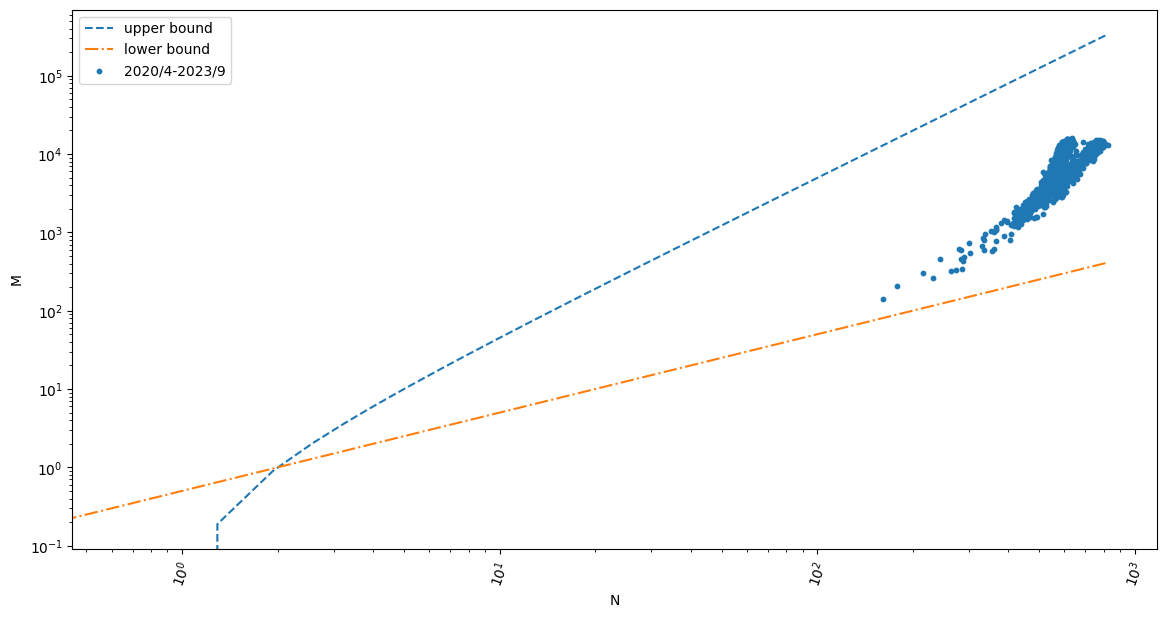

In [53]:
# Plot N-M Scaling in the whole time
node_list = all_nmt[0]
edge_list = all_nmt[1]
timestamp = all_nmt[2]

# Theoritical line
nn = len(node_list)
xmin = min(node_list)
xmax = max(node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.scatter(node_list, edge_list, marker='o', s=10, label="2020/4-2023/9")
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

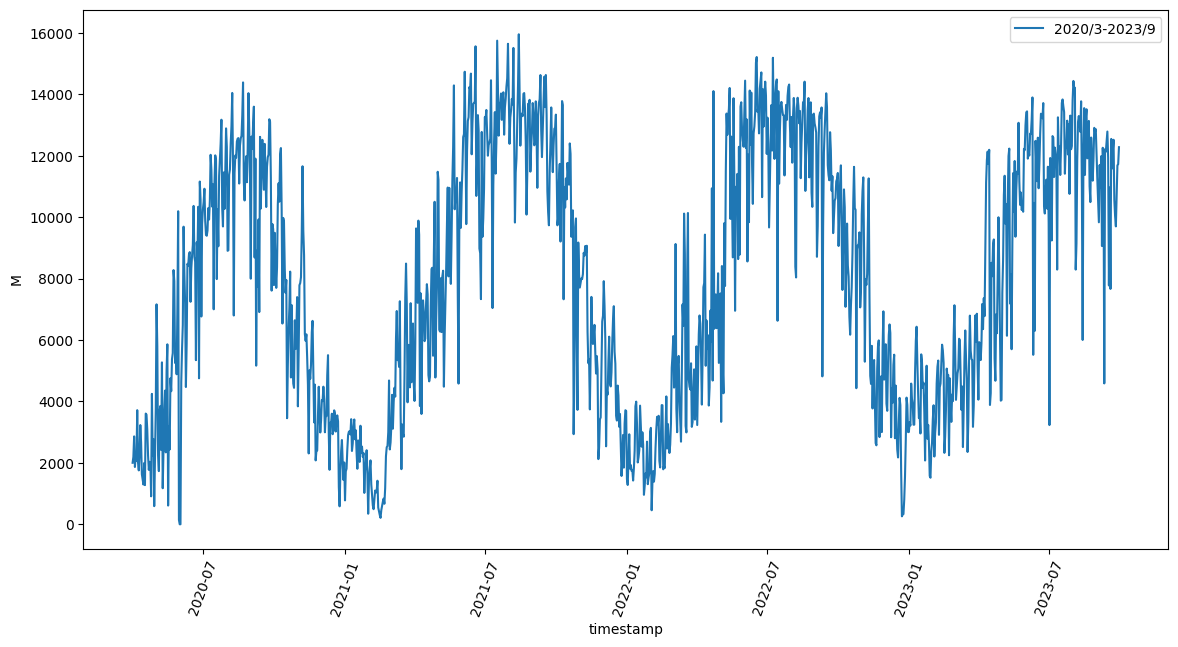

In [54]:
# Plot t-M Scaling in the whole time
plt.figure(figsize=(14,7))
plt.plot(timestamp, edge_list, label="2020/3-2023/9")
plt.xticks(rotation=70)
plt.xlabel("timestamp")
plt.ylabel("M")
plt.legend()
plt.show()

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_62312/667181302.py:18: RuntimeWarning: invalid value encountered in sqrt
  a = (1+np.sqrt(1+(32*x/kappa)))/2
/Users/ykaida/dev/chicago_master/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


kappa: 7.145131110803849e-05


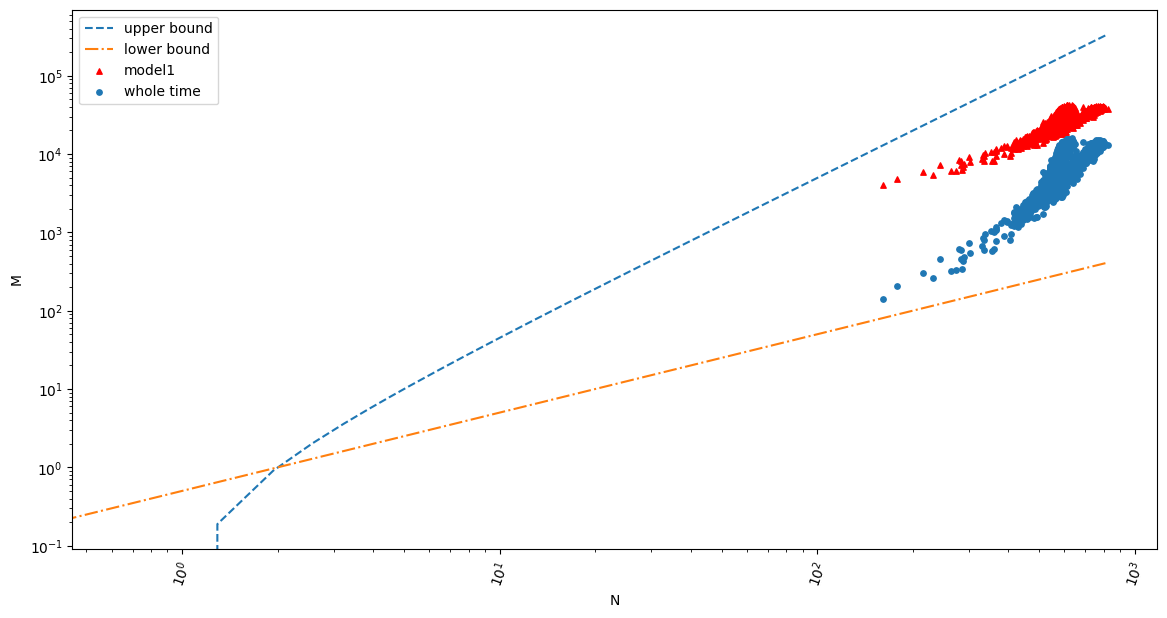

In [67]:
nn = len(node_list)
xmin = min(node_list)
xmax = max(node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

"""
model1を用いてフィッティングする
フィッティング用の計算をする
κを求める
κは非線形最小二乗法で求める
それを使ってNpを求める
κは定数、Npは可変
"""
from scipy.optimize import curve_fit
def model1(x, kappa, *params):
    a = (1+np.sqrt(1+(32*x/kappa)))/2
    return a*(1-2/a*kappa*(1-(1-kappa/2)**a))


# all_df[0]とall_df[1]をnp.arrayに変換
N = np.array(node_list)
M = np.array(edge_list)

# フィッティングする
p0 = [0.9,-0.9,0.5,-0.5]
popt, pcov = curve_fit(model1,N,M, p0=p0)
kappa = popt[0]
print("kappa:", kappa)

# Npを求める
Np = []
for i in range(len(M)):
    Np.append((1+np.sqrt(1+32*M[i]/kappa))/2)

plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
# 縦軸にNp, 横軸にNをとる
plt.scatter(N, Np, label="model1", marker="^", c="red", s=15)
plt.scatter(N, M, label="whole time", marker="o", s=15)
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


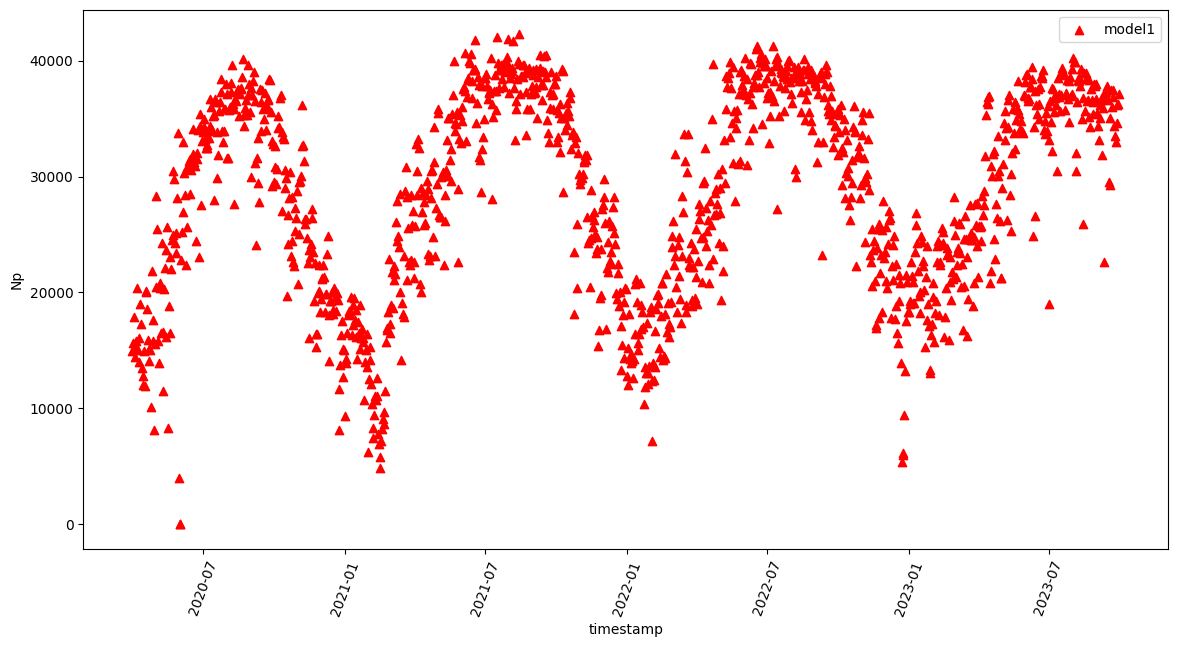

In [48]:
# timestampとNpをプロットする
plt.figure(figsize=(14,7))
plt.scatter(timestamp, Np, label="model1", marker="^", c="red")
plt.xticks(rotation=70)
plt.xlabel("timestamp")
plt.ylabel("Np")
plt.legend()
plt.show()


In [ ]:
"""model1再考

"""
p0 = [0.5, 0.9, -0.5, -0.9]
def model1(params, x, kappa):
    a = params[0]

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_62312/1805507842.py:12: RuntimeWarning: invalid value encountered in power
  res = Np-Np*(Np-1)*(1-(1-a/2)**Np)
/Users/ykaida/dev/chicago_master/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Np: 0.02874926171841211


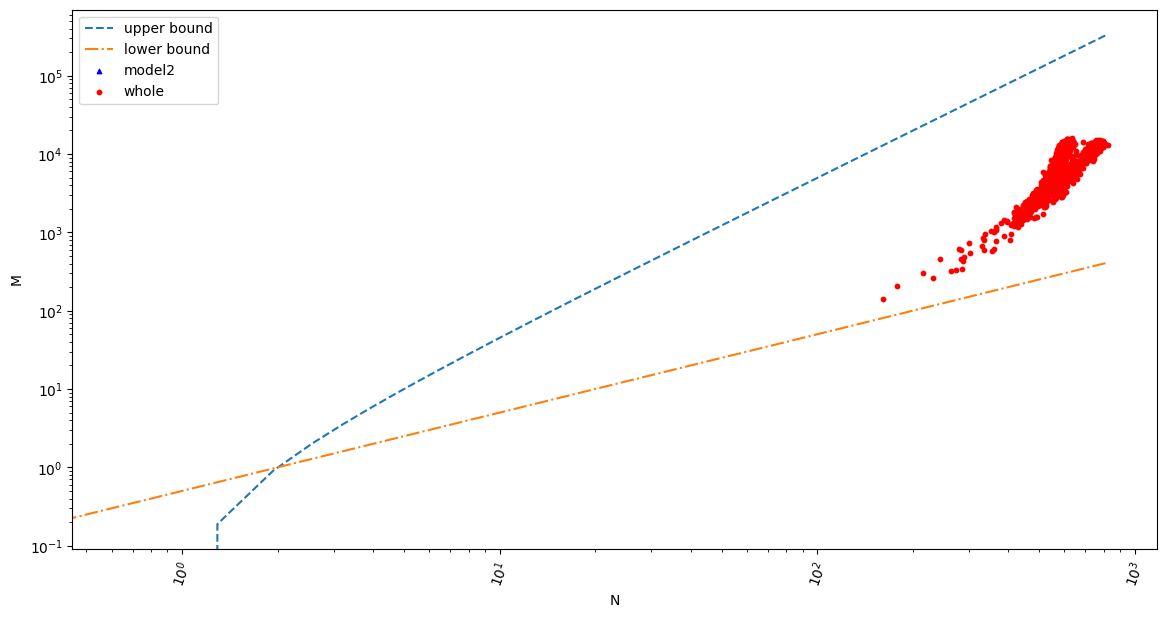

In [68]:
"""
model2を用いてフィッティング
Npは非線形最小二乗法で求める
κは可変、Npは定数
"""
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

def model2(x, Np, *params):
    a = 8*x/(Np**2-Np)
    res = Np-Np*(Np-1)*(1-(1-a/2)**Np)
    """
    # 分母が0になる場合があるので、その場合は0を返す
    if res.size == 0:
        return 0
    else:
    """
    return res

# フィッティングする
# 初期値を設定する
p0 = [0.9, -0.9, -0.5, 0.5, 0.5, -0.5, -0.9, 0.9]
popt, pcov = curve_fit(model2,M,N,p0=p0)
Np = popt[0]
print("Np:", Np)

# kappaを求める
kappa = []
for i in range(len(M)):
    kappa.append(8*M[i]/(Np**2-Np))

plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
# 縦軸にNp, 横軸にNをとる
plt.scatter(N, kappa, label="model2", marker="^", c="blue", s=10)
plt.scatter(N, M, label="whole", marker="o", s=10, c="red")
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


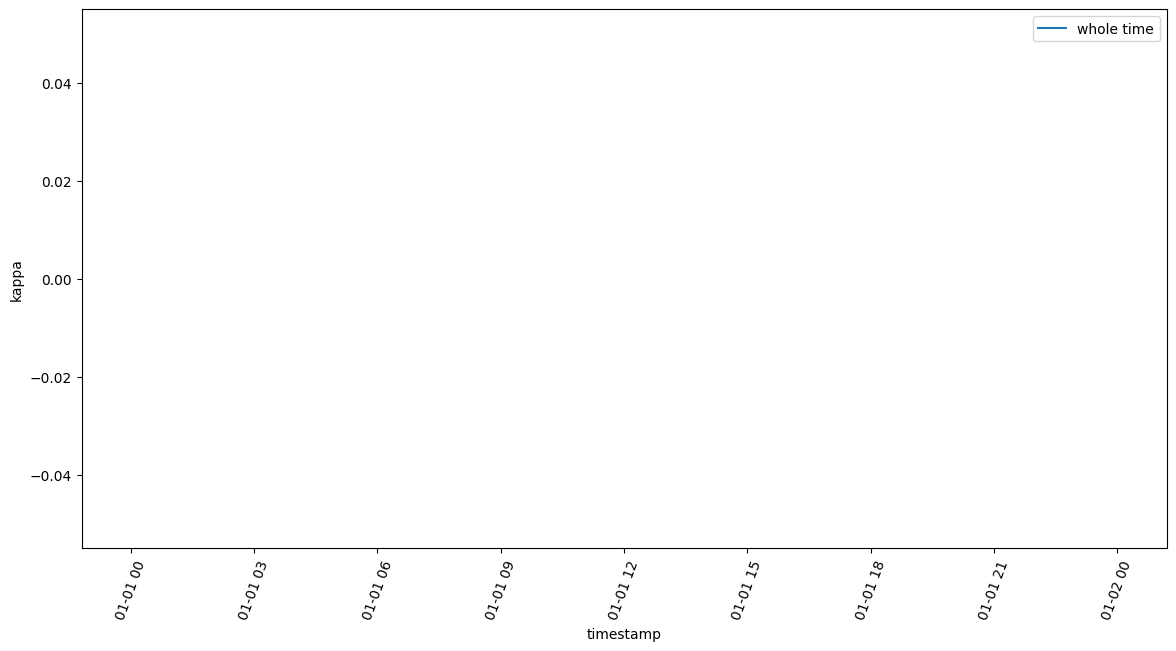

In [57]:
# Plot timestamp and kappa
plt.figure(figsize=(14,7))
plt.plot(timestamp, kappa, label="whole time")
plt.xticks(rotation=70)
plt.xlabel("timestamp")
plt.ylabel("kappa")
plt.legend()
plt.show()